# Leap Multitask Demo

Date: 2019/03/19

```
# Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
#   Licensed under the Apache License, Version 2.0 (the "License").
#   You may not use this file except in compliance with the License.
#   A copy of the License is located at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
#   or in the "license" file accompanying this file. This file is distributed
#   on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
#   express or implied. See the License for the specific language governing
#   permissions and limitations under the License.
# ==============================================================================
```

In [1]:
from mxnet import nd, autograd, gluon
import mxnet as mx


import numpy as np

import xfer.contrib.xfer_leap as leap
from xfer.contrib.xfer_leap.synthetic_data import MetaTaskSynthetic

### Set contexts

In [2]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

## Define tasks

In [3]:
config = {
    # Number examples per task and input dimensionality
    "num_examples_per_task": 300,
    "dim": 2,
    # task dependent bias and task independent bias
    "global_bias": 4.0,
    "task_bias": False,
    # Standard deviation of the covariates and the additive noise to the output
    "std_x": 1.0,
    "std_noise": 0.01,
    # Total number of tasks used for training/test
    "num_tasks_train": 4,
    "num_tasks_test": 0,
    "num_tasks_val": 0,
    # Total number of examples in each task that are hold out
    "hold_out": 100
    }

In [4]:
W = mx.nd.array([[0, 100, 20], [0, 120, 38], [0, 70, 70], [0, 39, 115]], ctx=data_ctx)

In [5]:
m = MetaTaskSynthetic(config, weights=W[:,1:], bias=W[:,0], context=mx.cpu(1))

In [6]:
batch_size = 4
train_data_all = m.get_train_tasks_iterators(batch_size=batch_size, train=True)

## Define and initialize network

In [7]:
net = gluon.nn.Dense(1, in_units=2, use_bias=False)

print(net.weight)
print(net.bias)

Parameter dense0_weight (shape=(1, 2), dtype=float32)
None


In [8]:
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

## Leap MetaRepurposer

In [9]:
lmr = leap.leap_meta_repurposer.LeapMetaRepurposer(model=net,
                                                   num_meta_steps=10,
                                                   num_epochs=7,
                                                   verbosity=2,
                                                   log_params=True)

In [10]:
lmr.repurpose(train_data_all, meta_batch_size=3)

	Metastep: 0, Task: 3, Initial Loss: 1524.031, Final Loss: 55.856, Loss delta: -1468.175
	Metastep: 0, Task: 3, Initial Loss: 1524.031, Final Loss: 55.856, Loss delta: -1468.175
	Metastep: 0, Task: 3, Initial Loss: 1524.031, Final Loss: 55.856, Loss delta: -1468.175
Metastep: 0, Num tasks: 3, Mean Loss: 48.656
	Metastep: 1, Task: 3, Initial Loss: 1226.654, Final Loss: 45.328, Loss delta: -1181.326
	Metastep: 1, Task: 3, Initial Loss: 1226.654, Final Loss: 45.328, Loss delta: -1181.326
	Metastep: 1, Task: 3, Initial Loss: 1226.654, Final Loss: 45.328, Loss delta: -1181.326
Metastep: 1, Num tasks: 3, Mean Loss: 47.424
	Metastep: 2, Task: 0, Initial Loss: 780.704, Final Loss: 26.029, Loss delta: -754.675
	Metastep: 2, Task: 2, Initial Loss: 543.415, Final Loss: 32.209, Loss delta: -511.206
	Metastep: 2, Task: 2, Initial Loss: 543.415, Final Loss: 32.209, Loss delta: -511.206
Metastep: 2, Num tasks: 3, Mean Loss: 38.863
	Metastep: 3, Task: 2, Initial Loss: 484.683, Final Loss: 29.110, Loss

## Plot Logs

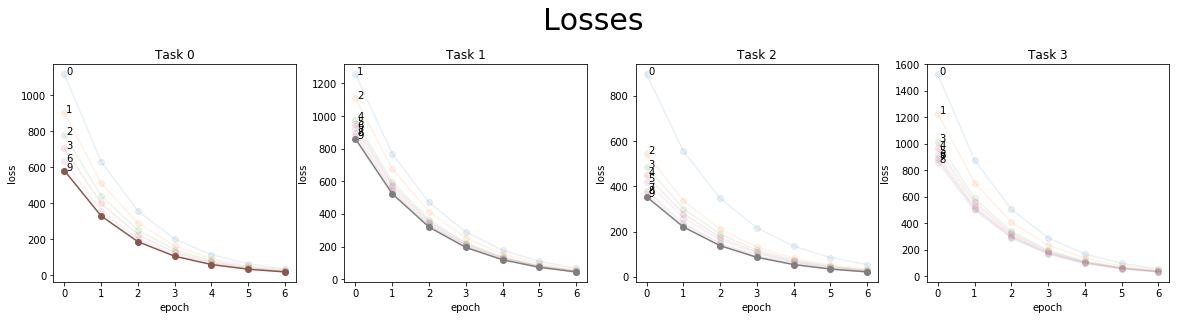

In [11]:
lmr.meta_logger.plot_losses()

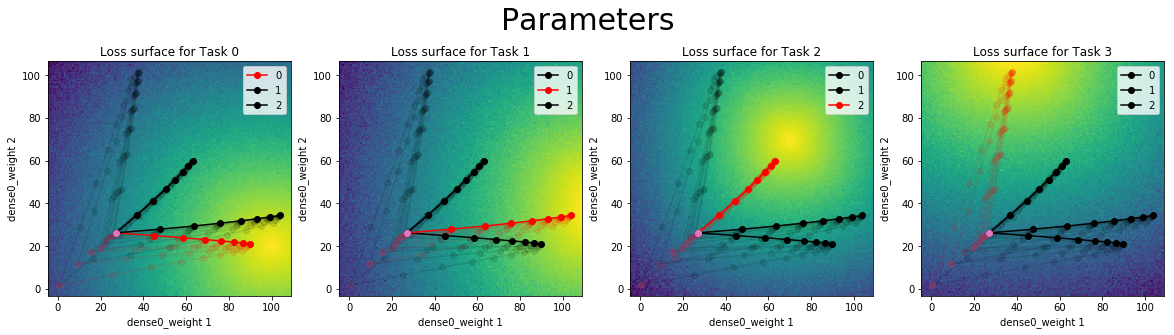

In [12]:
def real_fn(X, W):
    y = mx.nd.dot(X, mx.nd.expand_dims(W, axis=1))
    return y

def loss_fn(W_test, W_true, loss_samples=100):
    X = (mx.nd.random.uniform(shape=(loss_samples,2))-0.5)*100
    y_true = real_fn(X, W_true[1:])
    y_test = real_fn(X, W_test)
    loss = mx.nd.abs(y_true - y_test)
    return -mx.nd.mean(loss).asnumpy()[0]

lmr.meta_logger.plot_params(param='dense0_weight', W=W, loss_fn=loss_fn, loss_samples=200, gridsize=(150,150))